## Introduction


[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

### YoloV5



## Setup

### Configure API keys

To fine-tune YOLO5, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator` and set it to `GPU`.

In [2]:
!nvidia-smi

Sun Jan  5 05:37:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os

os.mkdir('yolo5')

FileExistsError: [Errno 17] File exists: 'yolo5'

In [5]:
os.chdir('yolo5')

In [7]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working/yolo5


## Install YOLO8 via Ultralytics

In [8]:
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 17088, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 17088 (delta 23), reused 7 (delta 7), pack-reused 17051 (from 3)
Receiving objects: 100% (17088/17088), 15.69 MiB | 32.53 MiB/s, done.
Resolving deltas: 100% (11723/11723), done.
/kaggle/working/yolo5/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 20.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-392-gf003c3df Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6037.7/8062.4 GB disk)


## Fine-tune YOLOV5 on River Plastic Waste Dataset

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = 'QIutYCrEaAHGulBxVoYa'

In [11]:
%ls

benchmarks.py    data/       LICENSE         README.zh-CN.md   tutorial.ipynb
CITATION.cff     detect.py   models/         requirements.txt  utils/
classify/        export.py   pyproject.toml  segment/          val.py
CONTRIBUTING.md  hubconf.py  README.md       train.py


In [12]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [13]:
%ls

benchmarks.py    data/       LICENSE         README.zh-CN.md   tutorial.ipynb
CITATION.cff     detect.py   models/         requirements.txt  utils/
classify/        export.py   pyproject.toml  segment/          val.py
CONTRIBUTING.md  hubconf.py  README.md       train.py


In [14]:
from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("project-zero").project("aerial_river_plastic_wastes")
version = project.version(10)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Aerial_River_Plastic_Wastes-10 in yolov5pytorch:: 100%|██████████| 4938/4938 [00:00<00:00, 7546.86it/s]


In [15]:
!ls

Aerial_River_Plastic_Wastes-10	data	    models	      segment
benchmarks.py			detect.py   pyproject.toml    train.py
CITATION.cff			export.py   README.md	      tutorial.ipynb
classify			hubconf.py  README.zh-CN.md   utils
CONTRIBUTING.md			LICENSE     requirements.txt  val.py


## Custom Training

Before training on our own custom dataset, we'll need do download some pre-trained weights so we aren't starting from scratch. This will accelerate the training process and improve the quality of our results.

**NOTE:** The results of the completed training are saved in `./yolo8/runs/segment/train/`. Let's examine them.

In [16]:
from utils.downloads import attempt_download

p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
cls = [f'{x}-seg' for x in p5]  # segmentation models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

100%|██████████| 4.11M/4.11M [00:00<00:00, 78.0MB/s]

100%|██████████| 14.9M/14.9M [00:00<00:00, 97.6MB/s]

100%|██████████| 42.4M/42.4M [00:00<00:00, 49.7MB/s]

100%|██████████| 91.9M/91.9M [00:01<00:00, 78.6MB/s]

100%|██████████| 170M/170M [00:02<00:00, 76.4MB/s] 



### Changing Parameters
`--batch, --epochs, --weights`  

#### List of Weights
- yolov5n-seg.pt
- yolov5s-seg.pt
- yolov5m-seg.pt
- yolov5l-seg.pt
- yolov5x-seg.pt

In [17]:
!python segment/train.py --img 640 --batch 16 --epochs 50 --data ./Aerial_River_Plastic_Wastes-10/data.yaml --weights yolov5x-seg.pt --device 0

2025-01-05 05:46:01.774688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 05:46:01.974895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 05:46:02.032478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
segment/train: weights=yolov5x-seg.pt, cfg=, data=./Aerial_River_Plastic_Wastes-10/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimize

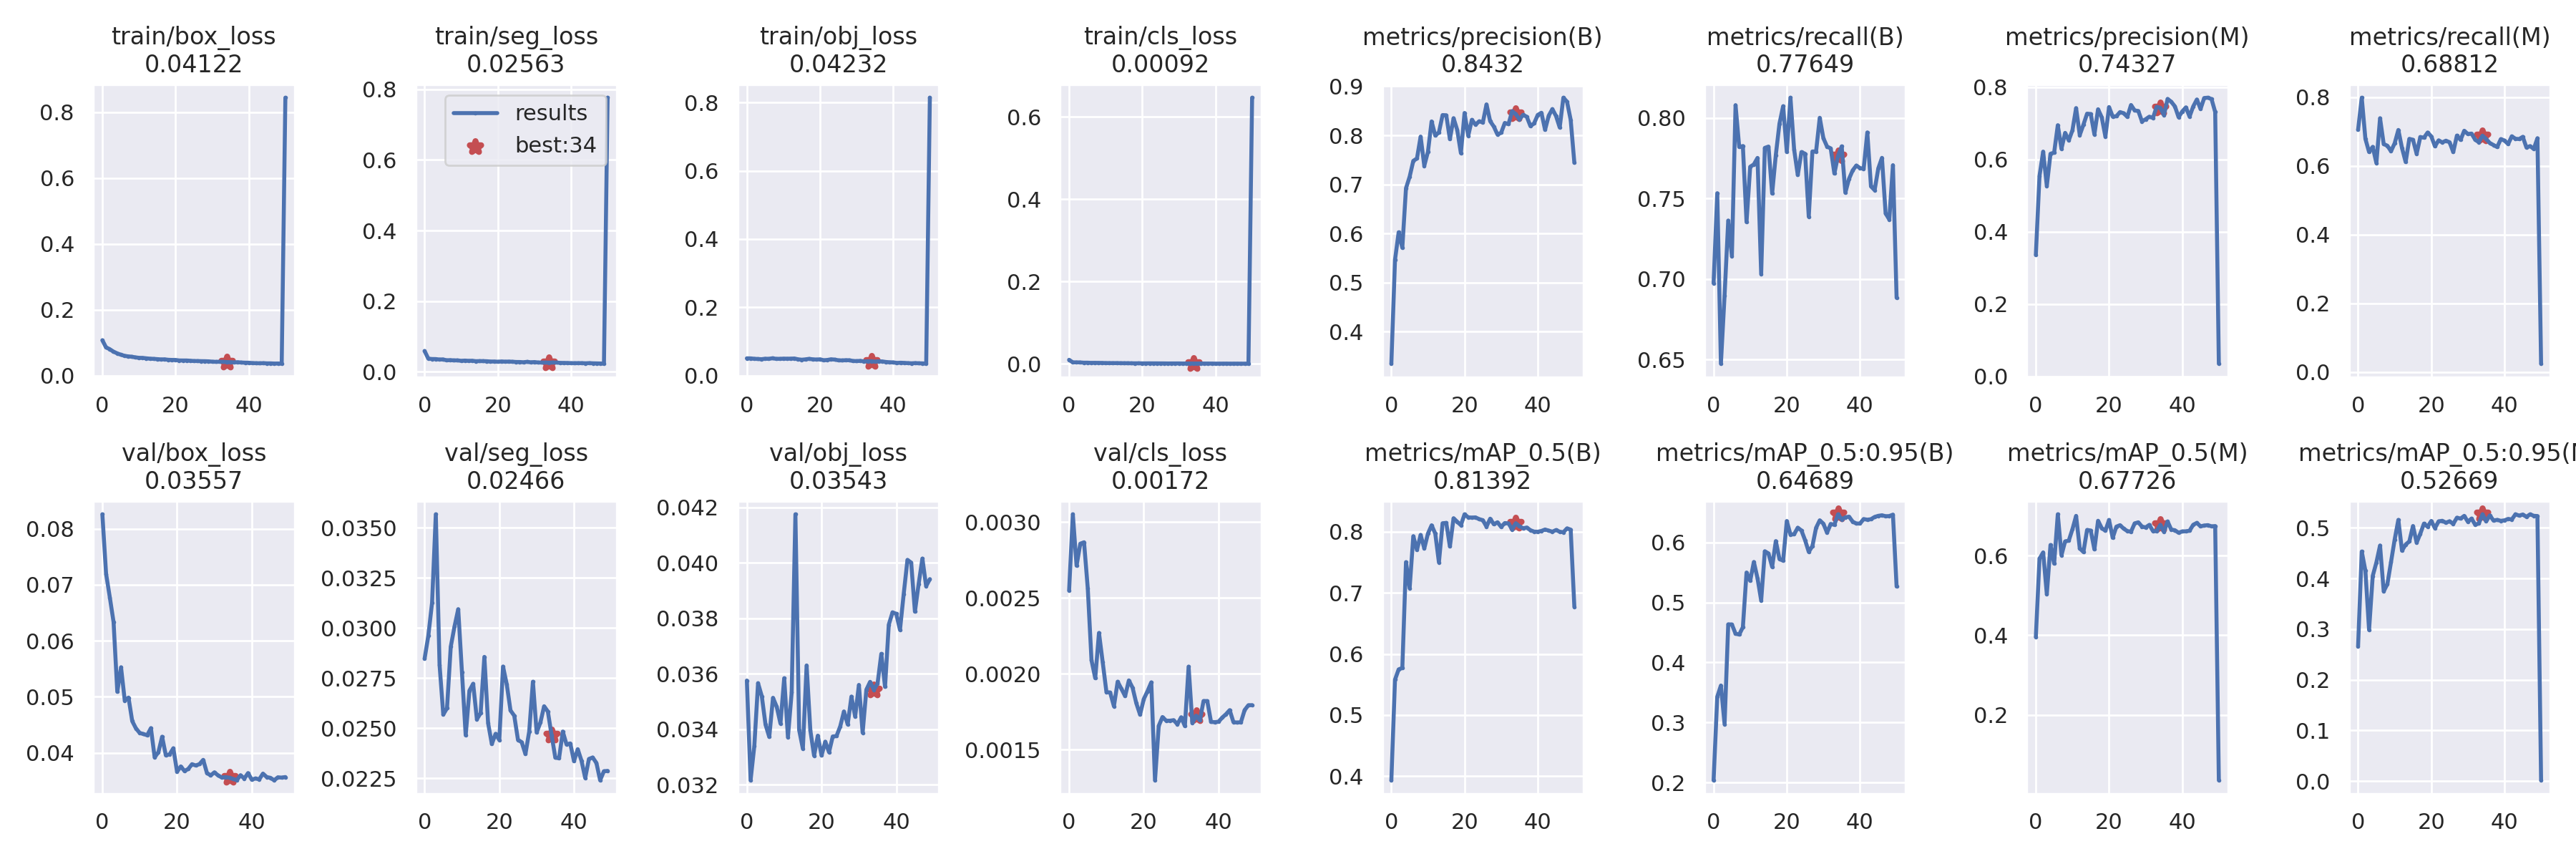

In [18]:
display.Image(filename=f'runs/train-seg/exp/results.png', width=1200) 

## Test and Validate the Custom Model

In [19]:
!python segment/val.py --weights runs/train-seg/exp/weights/best.pt --data ./Aerial_River_Plastic_Wastes-10/data.yaml --img 640

segment/val: data=./Aerial_River_Plastic_Wastes-10/data.yaml, weights=['runs/train-seg/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val-seg, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-392-gf003c3df Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 330 layers, 88249583 parameters, 0 gradients, 264.0 GFLOPs
val: Scanning /kaggle/working/yolo5/yolov5/Aerial_River_Plastic_Wastes-10/valid/
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         94       1049      0.844      0.774      0.816      0.648      0.752      0.694      0.687       0.54
               plastic         94        942      0.727      0.625      0.703      0.407      0.542      0.465  

## Inference with custom model
Next, we can try out inferring with our custom model. We'll pass an example image. In the notebook, note that we grab one of the images that comes in the test set folder that comes from the Roboflow data loader. This ensures that we're truly testing on an image our model did not see in training.

In [20]:
!python segment/predict.py --img 640 --weights runs/train-seg/exp/weights/best.pt --source ./Aerial_River_Plastic_Wastes-10/test/images/

segment/predict: weights=['runs/train-seg/exp/weights/best.pt'], source=./Aerial_River_Plastic_Wastes-10/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-392-gf003c3df Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 330 layers, 88249583 parameters, 0 gradients, 264.0 GFLOPs
image 1/95 /kaggle/working/yolo5/yolov5/Aerial_River_Plastic_Wastes-10/test/images/Aerial_Location_1_108_jpg.rf.0cd592574b46ddf6aa2e71c6b5240fc1.jpg: 640x640 16 plastics, 1 river, 38.0ms
image 2/95 /kaggle/working/yolo5/yolov5/Aerial_River_Plastic_Wastes-10/test/imag

## Downloading The results

In [21]:
%ls

Aerial_River_Plastic_Wastes-10/  detect.py     pyproject.toml    train.py
benchmarks.py                    export.py     README.md         tutorial.ipynb
CITATION.cff                     hubconf.py    README.zh-CN.md   utils/
classify/                        LICENSE       requirements.txt  val.py
CONTRIBUTING.md                  models/       runs/             weights/
data/                            __pycache__/  segment/          yolov5x-seg.pt


In [22]:
import shutil

%cd ..


/kaggle/working/yolo5


In [23]:
%ls

yolov5/


In [24]:
shutil.make_archive("1_yolo5_result", 'zip', "./yolov5")

'/kaggle/working/yolo5/1_yolo5_result.zip'

In [25]:
from google.colab import files

# Download the created ZIP file
#files.download('/kaggle/working/yolo5/yolov5/yolo5/1_yolo5_result.zip')
